<a href="https://colab.research.google.com/github/DanZter/QARIK_knowledge_graph_project/blob/master/information_extraction_python_and_spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction to Information Extraction using Python and spaCy**

https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

## 1. spaCy’s Rule-Based Matching

let’s try to extract hypernym-hyponym pairs by using these patterns/rules. We will use spaCy’s rule-based matcher to perform this task.

In [ ]:
# DEPENDENCIES
import re 
import string 
import nltk 
import spacy 
import pandas as pd 
import numpy as np 
import math 
from tqdm import tqdm 

from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 

pd.set_option('display.max_colwidth', 200)

# load spaCy model
nlp = spacy.load("en_core_web_sm")

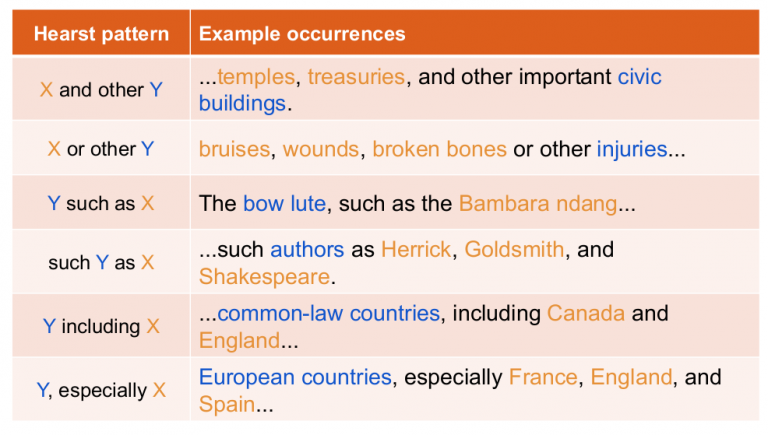

We are all set to mine information from text based on these Hearst Patterns.

In [ ]:
# sample text 
text = "GDP in developing countries such as Vietnam will continue growing at a high rate." 

# create a spaCy object 
doc = nlp(text)

To be able to pull out the desired information from the above sentence, it is really important to understand its syntactic structure – things like the subject, object, modifiers, and parts-of-speech (POS) in the sentence.

We can easily explore these syntactic details in the sentence by using spaCy:

* Pattern: X such as Y

In [ ]:
# print token, dependency, POS tag 
for tok in doc: 
  print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

GDP --> nsubj --> NOUN
in --> prep --> ADP
developing --> amod --> VERB
countries --> pobj --> NOUN
such --> amod --> ADJ
as --> prep --> SCONJ
Vietnam --> pobj --> PROPN
will --> aux --> VERB
continue --> ROOT --> VERB
growing --> xcomp --> VERB
at --> prep --> ADP
a --> det --> DET
high --> amod --> ADJ
rate --> pobj --> NOUN
. --> punct --> PUNCT


Have a look around the terms “such” and “as” . They are followed by a noun (“countries”). And after them, we have a proper noun (“Vietnam”) that acts as a hyponym.

So, let’s create the required pattern using the dependency tags and the POS tags:

In [ ]:
#define the pattern 
pattern = [{'POS':'NOUN'}, 
           {'LOWER': 'such'}, 
           {'LOWER': 'as'}, 
           {'POS': 'PROPN'} ]  #proper noun

Let’s extract the pattern from the text:

In [ ]:
# Matcher class object 
matcher = Matcher(nlp.vocab) 
matcher.add("matching_1", None, pattern) 

matches = matcher(doc) 
span = doc[matches[0][1]:matches[0][2]] 

print(matches[0][1], " to --->", matches[0][2])
print(span.text)

3  to ---> 7
countries such as Vietnam


Nice! It works perfectly. However, if we could get “developing countries” instead of just “countries”, then the output would make more sense.

So, we will now also capture the modifier of the noun just before “such as” by using the code below:

In [ ]:
# Matcher class object
matcher = Matcher(nlp.vocab)

#define the pattern
pattern = [{'DEP':'amod', 'OP':"?"}, # adjectival modifier
           {'POS':'NOUN'},
           {'LOWER': 'such'},
           {'LOWER': 'as'},
           {'POS': 'PROPN'}]

matcher.add("matching_1", None, pattern)
matches = matcher(doc)

span = doc[matches[0][1]:matches[0][2]]

print(matches[0][1], " to --->", matches[0][2])
print(span.text)

2  to ---> 7
developing countries such as Vietnam


Here, “developing countries” is the hypernym and “Vietnam” is the hyponym. Both of them are semantically related.

Note: The key ‘OP’: ‘?’ in the pattern above means that the modifier (‘amod’) can occur once or not at all.

In a similar manner, we can get several pairs from any piece of text:

* Fruits such as apples
* Cars such as Ferrari
* Flowers such as rose

Now let’s use some other Hearst Patterns to extract more hypernyms and hyponyms.

* Pattern: X and/or Y

In [ ]:
doc = nlp("Here is how you can keep your car and other vehicles clean.") 

# print dependency tags and POS tags
for tok in doc: 
  print(tok.text, "-->",tok.dep_, "-->",tok.pos_)

Here --> advmod --> ADV
is --> ROOT --> AUX
how --> advmod --> ADV
you --> nsubj --> PRON
can --> aux --> VERB
keep --> ccomp --> VERB
your --> poss --> DET
car --> dobj --> NOUN
and --> cc --> CCONJ
other --> amod --> ADJ
vehicles --> conj --> NOUN
clean --> oprd --> ADJ
. --> punct --> PUNCT


In [ ]:
# Matcher class object 
matcher = Matcher(nlp.vocab) 

#define the pattern 
pattern = [{'DEP':'amod', 'OP':"?"}, 
           {'POS':'NOUN'}, 
           {'LOWER': 'and', 'OP':"?"}, 
           {'LOWER': 'or', 'OP':"?"}, 
           {'LOWER': 'other'}, 
           {'POS': 'NOUN'}] 
           
matcher.add("matching_1", None, pattern) 

matches = matcher(doc) 
span = doc[matches[0][1]:matches[0][2]] 
print(matches[0][1], " to --->", matches[0][2])
print(span.text)

7  to ---> 11
car and other vehicles


Let’s try out the same code to capture the “X or Y” pattern:

In [ ]:
# replaced 'and' with 'or'
doc = nlp("Here is how you can keep your car or other vehicles clean.")

# Matcher class object 
matcher = Matcher(nlp.vocab) 

#define the pattern 
pattern = [{'DEP':'amod', 'OP':"?"}, 
           {'POS':'NOUN'}, 
           {'LOWER': 'and', 'OP':"?"}, 
           {'LOWER': 'or', 'OP':"?"}, 
           {'LOWER': 'other'}, 
           {'POS': 'NOUN'}] 
           
matcher.add("matching_1", None, pattern) 

matches = matcher(doc) 
span = doc[matches[0][1]:matches[0][2]] 
print(matches[0][1], " to --->", matches[0][2])
print(span.text)

7  to ---> 11
car or other vehicles


* Pattern: X, including Y

In [ ]:
doc = nlp("Eight people, including two children, were injured in the explosion") 

for tok in doc: 
  print(tok.text, "-->",tok.dep_, "-->",tok.pos_)

Eight --> nummod --> NUM
people --> nsubjpass --> NOUN
, --> punct --> PUNCT
including --> prep --> VERB
two --> nummod --> NUM
children --> pobj --> NOUN
, --> punct --> PUNCT
were --> auxpass --> AUX
injured --> ROOT --> VERB
in --> prep --> ADP
the --> det --> DET
explosion --> pobj --> NOUN


In [ ]:
# Matcher class object 
matcher = Matcher(nlp.vocab) 

#define the pattern 
pattern = [{'DEP':'nummod','OP':"?"}, # numeric modifier 
           {'DEP':'amod','OP':"?"}, # adjectival modifier 
           {'POS':'NOUN'}, 
           {'IS_PUNCT': True}, 
           {'LOWER': 'including'}, 
           {'DEP':'nummod','OP':"?"}, 
           {'DEP':'amod','OP':"?"}, 
           {'POS':'NOUN'}] 
                               
matcher.add("matching_1", None, pattern) 

matches = matcher(doc) 
span = doc[matches[0][1]:matches[0][2]] 
print(matches[0][1], " to --->", matches[0][2])
print(span.text)

0  to ---> 6
Eight people, including two children


* Pattern: X, especially Y

In [ ]:
doc = nlp("A healthy eating pattern includes fruits, especially whole fruits.") 

for tok in doc: 
  print(tok.text, "-->",tok.dep_, "-->",tok.pos_)

A --> det --> DET
healthy --> amod --> ADJ
eating --> amod --> VERB
pattern --> nsubj --> NOUN
includes --> ROOT --> VERB
fruits --> dobj --> NOUN
, --> punct --> PUNCT
especially --> advmod --> ADV
whole --> amod --> ADJ
fruits --> appos --> NOUN
. --> punct --> PUNCT


In [ ]:
# Matcher class object 
matcher = Matcher(nlp.vocab)

#define the pattern 
pattern = [{'DEP':'nummod','OP':"?"}, 
           {'DEP':'amod','OP':"?"}, 
           {'POS':'NOUN'}, 
           {'IS_PUNCT':True}, 
           {'LOWER': 'especially'}, 
           {'DEP':'nummod','OP':"?"}, 
           {'DEP':'amod','OP':"?"}, 
           {'POS':'NOUN'}] 
           
matcher.add("matching_1", None, pattern) 

matches = matcher(doc) 
span = doc[matches[0][1]:matches[0][2]] 
print(matches[0][1], " to --->", matches[0][2])
print(span.text)

5  to ---> 10
fruits, especially whole fruits


## 2. Subtree Matching for Relation Extraction

**We have to be extremely creative to come up with new rules to capture different patterns. It is difficult to build patterns that generalize well across different sentences.** 

To enhance the rule-based methods for relation/information extraction, we should try to understand the dependency structure of the sentences at hand.

Let’s take a sample text and build its dependency graphing tree:

# dependency graphs

In [ ]:
text = "Tableau was recently acquired by Salesforce." 

# Plot the dependency graph 
doc = nlp(text) 
displacy.render(doc, style='dep',jupyter=True)

Can you find any interesting relation in this sentence?

If you look at the entities in the sentence – Tableau and Salesforce – they are related by the term ‘acquired’. So, the pattern I can extract from this sentence is either “Salesforce acquired Tableau” or “X acquired Y”.

Now consider this statement: “Careem, a ride-hailing major in the middle east, was acquired by Uber.”

Its dependency graph will look something like this:

In [ ]:
text = "Careem, a ride-hailing major in the middle east, was acquired by Uber."

# Plot the dependency graph 
doc = nlp(text) 
displacy.render(doc, style='dep',jupyter=True)

In [ ]:
text = "john took decision in NI assembly"


# Plot the dependency graph 
doc = nlp(text) 
displacy.render(doc, style='dep',jupyter=True)

Pretty scary, right?

Don’t worry! All we have to check is which dependency paths are common between multiple sentences. This method is known as Subtree matching.

For instance, if we compare this statement with the previous one:

![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/09/DG_3.png)
![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/09/DG_4.png)

We will just consider the common dependency paths and extract the entities and the relation (acquired) between them. Hence, the relations extracted from these sentences are:

* Salesforce acquired Tableau
* Uber acquired Careem

Let’s try to implement this technique in Python. We will again use spaCy as it makes it pretty easy to traverse a dependency tree.

We will start by taking a look at the dependency tags and POS tags of the words in the sentence:

In [ ]:
text = "Tableau was recently acquired by Salesforce." 
doc = nlp(text) 

for tok in doc: 
  print(tok.text,"-->",tok.dep_,"-->",tok.pos_)

Tableau --> nsubjpass --> PROPN
was --> auxpass --> AUX
recently --> advmod --> ADV
acquired --> ROOT --> VERB
by --> agent --> ADP
Salesforce --> pobj --> PROPN
. --> punct --> PUNCT


Here, the dependency tag for “Tableau” is nsubjpass which stands for a passive subject (as it is a passive sentence). The other entity “Salesforce” is the object in this sentence and the term “acquired” is the ROOT of the sentence which means it somehow connects the object and the subject.

Let’s define a function to perform subtree matching:

In [ ]:
def subtree_matcher(doc): 
  x = '' 
  y = '' 
  
  # iterate through all the tokens in the input sentence 
  for i,tok in enumerate(doc): 
    # extract subject 
    if tok.dep_.find("subjpass") == True: 
      y = tok.text 
      
    # extract object 
    if tok.dep_.endswith("obj") == True: 
      x = tok.text 
      
  return x,y

In [ ]:
subtree_matcher(doc)

('Salesforce', 'Tableau')

Here, the subject is the acquirer and the object is the entity that is getting acquired. Let’s use the same function, subtree_matcher( ), to extract entities related by the same relation (“acquired”):

In [ ]:
text_2 = "Careem, a ride hailing major in middle east, was acquired by Uber." 

doc_2 = nlp(text_2) 
subtree_matcher(doc_2)

('Uber', 'Careem')

Did you see what happened here? This sentence had more words and punctuation marks but still, our logic worked and successfully extracted the related entities.

But wait – what if I change the sentence from passive to active voice? Will our logic still work?

In [ ]:
text_3 = "Salesforce recently acquired Tableau." 
doc_3 = nlp(text_3) 
subtree_matcher(doc_3)

('Tableau', '')

That’s not quite what we expected. The function has failed to capture ‘Salesforce’ and wrongly returned ‘Tableau’ as the acquirer.

So, what could go wrong? Let’s understand the dependency tree of this sentence:

In [ ]:
for tok in doc_3:    
  print(tok.text, "-->",tok.dep_, "-->",tok.pos_)

Salesforce --> nsubj --> NOUN
recently --> advmod --> ADV
acquired --> ROOT --> VERB
Tableau --> dobj --> PROPN
. --> punct --> PUNCT


It turns out that the grammatical functions (subject and object) of the terms ‘Salesforce’ and ‘Tableau’ have been interchanged in the active voice. However, now the dependency tag for the subject has changed to ‘nsubj’ from ‘nsubjpass’. This tag indicates that the sentence is in the active voice.

We can use this property to modify our subtree matching function. Given below is the new function for subtree matching:

In [ ]:
def new_subtree_matcher(doc):
  subjpass = 0

  for i,tok in enumerate(doc):
    # find dependency tag that contains the text "subjpass"    
    if tok.dep_.find("subjpass") == True:
      subjpass = 1

  x = ''
  y = ''

  # if subjpass == 1 then sentence is passive
  if subjpass == 1:
    for i,tok in enumerate(doc):
      if tok.dep_.find("subjpass") == True:
        y = tok.text

      if tok.dep_.endswith("obj") == True:
        x = tok.text
  
  # if subjpass == 0 then sentence is not passive
  else:
    for i,tok in enumerate(doc):
      if tok.dep_.endswith("subj") == True:
        x = tok.text

      if tok.dep_.endswith("obj") == True:
        y = tok.text

  return x,y

In [ ]:
new_subtree_matcher(doc_3)

('Salesforce', 'Tableau')

Great! The output is correct. Let’s pass the previous passive sentence to this function:

In [ ]:
new_subtree_matcher(nlp("Tableau was recently acquired by Salesforce."))

('Salesforce', 'Tableau')

That’s exactly what we were looking for. We have made the function slightly more general. I would urge you to deep dive into the grammatical structure of different types of sentences and try to make this function more flexible.

# FIN